### Ref
https://arxiv.org/pdf/1901.03662.pdf

### Import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import sys
sys.path.append('./dev/')

In [4]:
from fastai import *
from fastai.vision import *
from ipyexperiments import *

from data_utils import *
from model_utils import *
from metric_utils import *
from loss_utils import *
from recorder import *
seed_everything(42)

### Read Data

In [5]:
data_path = Path('../data/whale/')

In [6]:
sorted(data_path.ls())

[PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/cropped_train'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/old_data'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/test'),
 PosixPath('../data/whale/test_bbox.csv'),
 PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/train_bbox.csv')]

In [7]:
# read all csv files
train_df = pd.read_csv(data_path/'train.csv')
train_bbox_df = pd.read_csv(data_path/'train_bbox.csv')
test_bbox_df = pd.read_csv(data_path/'test_bbox.csv')

In [8]:
train_df.shape, train_bbox_df.shape, test_bbox_df.shape

((25361, 2), (25361, 4), (7960, 3))

In [9]:
train_images = grab_image_files(data_path/'train')
test_images = grab_image_files(data_path/'test')
cropped_train_images = grab_image_files(data_path/'cropped_train')
cropped_test_images = grab_image_files(data_path/'cropped_test')
old_train_images = grab_image_files(data_path/'old_data/train')
old_test_images = grab_image_files(data_path/'old_data/test')

In [10]:
(len(train_images), len(cropped_train_images), len(test_images), 
 len(cropped_test_images), len(old_train_images), len(old_test_images))

(25361, 25361, 7960, 7960, 9850, 15610)

In [11]:
train_bbox_df.head(2)

,Image,Id,sizes,keras_model_bbox
0,0000e88ab.jpg,w_f48451c,"[3, 700, 1050]","(233, 160, 852, 417)"
1,0001f9222.jpg,w_c3d896a,"[3, 325, 758]","(0, 79, 744, 239)"


In [12]:
test_bbox_df.head(2)

,Image,sizes,keras_model_bbox
0,93e06c790.jpg,"[3, 375, 1050]","(0, 0, 1024, 357)"
1,617d85eb3.jpg,"[3, 525, 1050]","(15, 100, 1022, 370)"


In [13]:
train_df.head(2)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


### Create train-val known whales

In [21]:
training_df, validation_df = get_training_validation_df(train_df, valid_pct=0.05)

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


In [22]:
training_df.shape, validation_df.shape

((21927, 2), (3434, 2))

In [23]:
# filter out 'new_whale'
training_df = training_df[training_df.Id != 'new_whale']
validation_df = validation_df[validation_df.Id != 'new_whale']

In [24]:
training_df.shape, validation_df.shape

((12746, 2), (2951, 2))

### Databunch

In [18]:
tfms = get_transforms(max_rotate=15, p_affine=0.5, p_lighting=0.5, max_warp=0.1, max_zoom=0.05)
        
data = ImageDataBunch.from_df(path=data_path, df=training_df, ds_tfms=tfms,
                              folder='cropped_train', valid_pct=0., size=112,
                              resize_method=ResizeMethod.SQUISH, padding_mode="zeros")

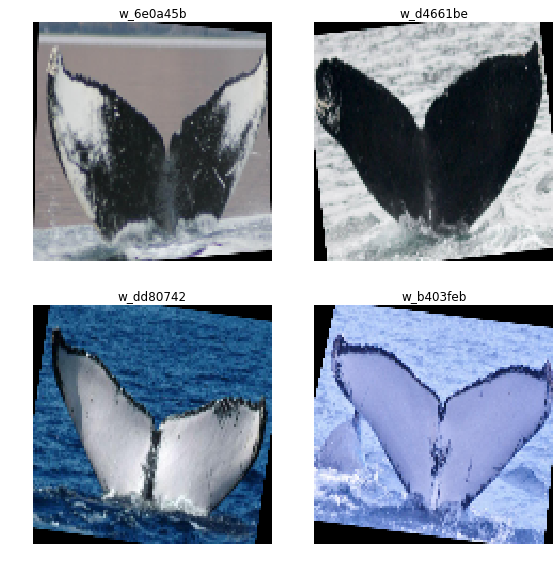

In [19]:
data.show_batch(2)

In [20]:
%%time
xb, yb = data.one_batch()

CPU times: user 372 ms, sys: 248 ms, total: 620 ms
Wall time: 3.51 s


In [21]:
xb.shape, yb.shape

(torch.Size([64, 3, 112, 112]), torch.Size([64]))

### Sample P class x K image

3358 images have only single image which can't be anchor.

In [14]:
class PK_BatchSampler(Sampler):
    "samples randomly p classes and k images per class each batch"
    def __init__(self, data_source, p=50, k=4, drop_last=True):
        "data_source : data.train_ds"
        self.data_source = data_source
        self.y = self.data_source.y.items
        self.unique_classes = np.random.permutation(np.unique(data_source.y.items))
        self.p = p
        self.k = k
        self._get_y2i()
        if drop_last: self._n = math.floor(len(self.unique_classes)/self.p)
        else: self._n = math.ceil(len(self.unique_classes)/self.p)
            
    def _get_y2i(self):
        "map y:target values to dataset idxs"
        self.y2i = defaultdict(list)
        for i, y in enumerate(self.y): self.y2i[y].append(i)
        
    def __iter__(self):
        "yields random batch approx self.p x min(len(idxs), self.k)"
        anchor_absence = True
        self.unique_classes = np.random.permutation(self.unique_classes)
        for i in range(self._n):
            batch = []     
            classes = self.unique_classes[i*self.p:(i+1)*self.p]
            for y in classes:
                idxs = self.y2i[y]
                if len(idxs) > 1: anchor_absence = False
                batch += list(np.random.permutation(idxs)[:self.k])
            yield batch
        if anchor_absence: raise ValueError("There is no anchor image")

    def __len__(self):
        return self._n

### Loss

In [15]:
# TODO: Optimize - CPU bound
from itertools import combinations
class OnlineHardTripletLoss(nn.Module):
    "take input embedding and coresponding classes to compute hard batch triplet loss"
    def __init__(self, hard_mining):
        super().__init__()
        self.hard_mining = hard_mining
    
    def forward(self, input, target):
        "input: embeddings, target: classes"
        y2i = defaultdict(list)
        for i, y in enumerate(target.tolist()): y2i[y].append(i)
        i2y = dict(enumerate(target.tolist()))
        target_idxs = np.arange(len(target))
        
        "get anchor-positive pairs"
        anchor_positive_idxs = []
        for y in y2i:
            anchor_idxs = y2i[y]
            if len(anchor_idxs) > 1:
                anchor_positive_idxs += list(combinations(anchor_idxs, 2))

        "get anchor-positive-negative triplets"
        anchor_positive_negative_idxs = []
        for a,p in anchor_positive_idxs:
            anchor = i2y[a]
            negative_idxs = [i for i in target_idxs if i not in y2i[anchor]]
            for n in negative_idxs: anchor_positive_negative_idxs.append((a,p,n))
        
        "get anc-pos-neg idxs"
        anc, pos, neg = zip(*anchor_positive_negative_idxs)
        
        "calc softplus triplet loss"
        losses = torch.log(1 + torch.exp((1 - F.cosine_similarity(input[list(anc)], input[list(pos)])) 
                                         - (1 - F.cosine_similarity(input[list(anc)], input[list(neg)]))))
                
        "if hard_mining=True, only hardest triplet for each anchor"
        if self.hard_mining: 
            y2loss = defaultdict(list)
            for a_idx, loss in zip(anc, losses):
                y = i2y[a_idx]
                y2loss[y].append(loss)
            max_losses = []
            for y in y2loss:
                y_losses = y2loss[y]
                max_losses.append(y_losses[torch.argmax(tensor(y_losses))])
            loss = (sum(max_losses)/len(max_losses))
                        
        else: loss = losses.mean()
        return loss

In [159]:
%%time
loss_func = OnlineHardTripletLoss(hard_mining=False)
print(loss_func(embs, yb))

tensor(0.6916)
CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 38.7 ms


In [160]:
%%time
loss_func = OnlineHardTripletLoss(hard_mining=True)
print(loss_func(embs, yb))

tensor(0.8575)
CPU times: user 456 ms, sys: 28 ms, total: 484 ms
Wall time: 149 ms


### Model

In [83]:
from fastai.vision.learner import model_meta

In [84]:
np.array([m for m in dir(models) if m[:2] != "__"])

array(['BasicBlock', 'Darknet', 'DynamicUnet', 'ResLayer', 'ResNet', 'SqueezeNet', 'UnetBlock', 'WideResNet',
       'XResNet', 'alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'resnet101',
       'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'unet', 'vgg16_bn',
       'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152', 'xresnet18', 'xresnet34',
       'xresnet50'], dtype='<U13')

In [85]:
# model recipe
arch = models.resnet34
custom_cnn = nn.Sequential(*[create_body(arch=arch, pretrained=True),
                            AdaptiveConcatPool2d(),
                            Flatten()]
                            + bn_drop_lin(n_in=1024, n_out=1024, bn=True, p=0.5, actn=nn.ReLU())
                            + bn_drop_lin(n_in=1024, n_out=128, bn=True, p=0.5, actn=None)).cuda()

In [158]:
loss_func = OnlineHardTripletLoss(hard_mining=False)
learn = Learner(data=data, model=custom_cnn, loss_func=loss_func)
splits = split_model_idx(learn.model, [50,90]) 
learn.split(splits)

In [ ]:
learn.lr_find()

Min numerical gradient: 3.02E-03


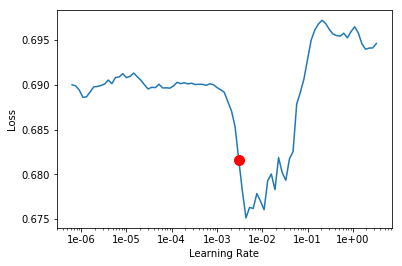

In [81]:
learn.recorder.plot(suggestion=True)

In [87]:
learn.fit_one_cycle(5, max_lr=3e-3)

### Evaluation Metric map@k

In [44]:
from data_utils import *

In [45]:
def calc_query_vocab_embs(model, vocab_df=training_df, valid_df=training_df, bs=64, size=112):
    "model: embedding extractor for vocab (training) and query (valid/test)"
    vocab_dl = create_unshuffled_dl(vocab_df, data_path, 'cropped_train', bs=bs, size=size)
    query_dl = create_unshuffled_dl(valid_df, data_path, 'cropped_train', bs=bs, size=size)
    vocab_emb = module_predict_dl(model, vocab_dl)
    query_emb = module_predict_dl(model, query_dl)
    return query_emb, vocab_emb

In [46]:
def get_pairwise_targets(vocab_targets=training_df['Id'].values, 
                         valid_targets=validation_df['Id'].values):
    w2i = {w:i for i,w in enumerate(vocab_targets)}
    vocab_i = torch.from_numpy(np.array([w2i[w] for w in vocab_targets]))
    query_i = torch.from_numpy(np.array([w2i[w] for w in valid_targets]))
    return pairwise_rel(query_i, vocab_i)

In [47]:
def get_pair_idxs(query_emb, vocab_emb):
    n_query, n_vocab = len(query_emb), len(vocab_emb)
    pair_idxs = []
    for i in range(n_query):
        for j in range(n_query, n_query + n_vocab):
            pair_idxs.append((i,j))
    return pair_idxs

In [48]:
def get_pair_emb_dl(query_emb, vocab_emb, pair_idxs, bs=4096):
    query_vocab_emb = torch.cat([query_emb, vocab_emb])
    pair_emb_ds = PairEmbeddingDataset(query_vocab_emb, pair_idxs)
    pair_emb_dl = DeviceDataLoader(DataLoader(pair_emb_ds, batch_size=bs, 
                                              shuffle=False, num_workers=defaults.cpus), device=0)
    return pair_emb_dl

In [50]:
class CosineSimilarity(nn.Module):
    "torch module for cosine similarity"
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return F.cosine_similarity(input[0], input[1])

class mapk_metric(LearnerCallback):
    """
    Computes mean precision @k at every n epoch 
     - https://docs.fast.ai/metrics.html#Creating-your-own-metric
    """
    _order=-20 
    def __init__(self, learn, k=5, every=5, sim_module=CosineSimilarity()):      
        super().__init__(learn)
        self.k = k
        self.every = every
        self.sim_module = sim_module
        
    def on_train_begin(self, **kwargs): 
        "init number of epochs since training"
        self.n_epoch = 0
        self.image_size = self.learn.data.train_ds.tfmargs['size']
        self.learn.recorder.add_metric_names([f'map@{self.k}'])
        
    def _calc_mapk(self, **kwargs):
        "calculate map@k"
        query_emb, vocab_emb = calc_query_vocab_embs(self.learn.model, vocab_df=training_df,
                                                     valid_df=validation_df, bs=64, size=self.image_size)
        pwise_targets = get_pairwise_targets()
        pair_idxs = get_pair_idxs(query_emb, vocab_emb)
        pair_emb_dl = get_pair_emb_dl(query_emb, vocab_emb, pair_idxs, bs=100000)
        sim_scores = module_predict_dl(self.sim_module, pair_emb_dl)
        pwise_distances = 1 - sim_scores.view(query_emb.size(0), vocab_emb.size(0))
        return mapk(pwise_distances, pwise_targets, k=self.k)
        
    def on_epoch_end(self, **kwargs):
        "compute metric every n epochs"
        self.n_epoch += 1
        if (self.n_epoch % self.every) == 0: 
            self.learn.recorder.add_metrics([self._calc_mapk()])
        else:
            self.learn.recorder.add_metrics([None])

### Training

In [57]:
from warnings import filterwarnings

In [58]:
filterwarnings("ignore")

In [59]:
# data
tfms = get_transforms(do_flip=False, max_rotate=15, p_affine=0.5, p_lighting=0.5, max_warp=0.1, max_zoom=0.05)

data = ImageDataBunch.from_df(path=data_path, df=training_df, ds_tfms=tfms,
                              folder='cropped_train', valid_pct=0., size=224,
                              resize_method=ResizeMethod.SQUISH, padding_mode="zeros")

In [60]:
# pk sampler
batch_sampler = PK_BatchSampler(data_source=data.train_ds, p=30, k=4, drop_last=True)
train_dl = DataLoader(data.train_ds, batch_sampler=batch_sampler, collate_fn=data_collate, num_workers=defaults.cpus)
valid_dl = DataLoader(data.valid_ds, collate_fn=data_collate, num_workers=defaults.cpus)
data = DataBunch(train_dl, valid_dl)

In [61]:
# model recipe
arch = models.resnet34
custom_cnn = nn.Sequential(*[create_body(arch=arch, pretrained=True),
                            AdaptiveConcatPool2d(),
                            Flatten()]
                            + bn_drop_lin(n_in=1024, n_out=1024, bn=True, p=0.3, actn=nn.ReLU())
                            + bn_drop_lin(n_in=1024, n_out=128, bn=True, p=0.3, actn=None)).cuda()

In [64]:
# learner
loss_func = OnlineHardTripletLoss(hard_mining=False)
learn = Learner(data=data, model=custom_cnn, loss_func=loss_func, 
                callback_fns=partial(mapk_metric, k=5, every=50, sim_module=CosineSimilarity()))
splits = split_model_idx(learn.model, [50,-10]) 
learn.split(splits)

In [65]:
learn.load("224");

In [38]:
lr = 2e-3
learn.fit_one_cycle(20, lr)

In [66]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(400, max_lr=[lr/10, lr/3, lr])

In [68]:
learn.save("224")

### Hard Triplet Mining

In [69]:
loss_func = OnlineHardTripletLoss(hard_mining=True)
learn.loss_func = loss_func

In [ ]:
learn.fit_one_cycle(400, max_lr=[lr/10, lr/3, lr])

In [ ]:
learn.fit_one_cycle(400, max_lr=lr)

In [ ]:
learn.save("224-hard")